### Code for Cross Validation

In [1]:
!pip install ptflops

In [2]:
import gc
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import copy
from dataclasses import dataclass
import cv2
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        print(image_path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
        print(type(image))
        print(image.shape)
        break

/kaggle/input/data_balanced/validation/DEF/validation_DEF_238.jpeg
<class 'numpy.ndarray'>
(180, 180, 3)
/kaggle/input/data_balanced/validation/OK/validation_OK_467.jpeg
<class 'numpy.ndarray'>
(180, 180, 3)
/kaggle/input/data_balanced/test/DEF/test_DEF_375.jpeg
<class 'numpy.ndarray'>
(180, 180, 3)
/kaggle/input/data_balanced/test/OK/test_OK_152.jpeg
<class 'numpy.ndarray'>
(180, 180, 3)
/kaggle/input/data_balanced/train/DEF/train_DEF_102.jpeg
<class 'numpy.ndarray'>
(180, 180, 3)
/kaggle/input/data_balanced/train/OK/train_OK_51.jpeg
<class 'numpy.ndarray'>
(180, 180, 3)


In [3]:
@dataclass
class ModelArgs:
    # Hyperparameters
    num_classes: int = 2
    learning_rate: float = 3e-4
    batch_size: int = 64
    num_epochs: int = 15 # 100
    patience: int = 10
    manual_seed: int = 42
    k_folds: int = 3 
    factor: int = 4
    num_linear: int = 256
    generator: torch.Generator = torch.Generator().manual_seed(manual_seed)
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_args = ModelArgs()
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(model_args.manual_seed)

In [4]:
class CustomDataset:
    def __init__(self, image_paths, targets, augmentations = None):
        self.image_paths = image_paths
        self.targets = targets
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        target = self.targets[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
          "image": torch.tensor(image),
          "target": torch.tensor(target)
      }

In [5]:
def create_dataset(phase):
    image_paths = []
    targets = []
    classes = {'DEF':0, 'OK':1}
    dirname = '/kaggle/input/data_balanced/'
    for target in os.listdir(dirname +f'{phase}/'):
        folder_name = dirname +f'{phase}/{target}/'
        for image_path in os.listdir(folder_name):
            image_paths.append(folder_name + image_path)
            targets.append(classes.get(target, None))
    
    return image_paths, targets

In [6]:
phases = ['train', 'validation', 'test']
paths_cv = []
targets_cv = []
datasets = {}
for phase in phases:
    image_paths, targets = create_dataset(phase)
    if phase!='test':
        paths_cv.extend(image_paths)
        targets_cv.extend(targets)
        if phase =='validation':
            datasets['train'] = CustomDataset(paths_cv, targets_cv)
        continue
    else:
        datasets['test'] = CustomDataset(image_paths, targets)

datasets

{'train': <__main__.CustomDataset at 0x7f9566fa3760>,
 'test': <__main__.CustomDataset at 0x7f9566fa2b90>}

In [7]:
class SoftAttention(nn.Module):
    def __init__(self,channels: int,mh: int,concat_with_x: bool,aggregate: bool, model_args: ModelArgs):
        super().__init__()
        self.channels=int(channels)
        self.multiheads = mh # 16
        self.aggregate_channels = aggregate # False
        self.concat_input_with_scaled = concat_with_x # False
        self.device = model_args.device
        self.generator = model_args.generator
        self.kernel_shape_conv3d = (self.multiheads, 1, self.channels, 1, 1)
        self.kernel_conv3d = nn.Parameter(torch.randn(self.kernel_shape_conv3d, generator=self.generator).to(self.device))
        self.conv3d_bias = nn.Parameter(torch.zeros((self.multiheads)).to(self.device))
        
    def forward(self, x: torch.Tensor):
        # (None, 3, 180, 180) -> (None, 3, 180, 180, 1)
        exp_x = x.unsqueeze(dim=1)
#         print("After expand:", exp_x.shape)
        # (None, 1, 3, 180, 180) -> (None, 16, 1, 180, 180)
        conv3d = F.conv3d(exp_x, self.kernel_conv3d, bias = self.conv3d_bias)
#         print("After conv3d:", conv3d.shape)
        
        conv3d = F.relu(conv3d)

        # (None, 16, 1, 180, 180) -> (None, 16, 180, 180)
        conv3d = conv3d.squeeze()
#         print("After Squeeze:", conv3d.shape)

        # (None, 16, 180, 180) -> (None, 16, 32400)
        conv3d = conv3d.reshape((-1, self.multiheads, x.shape[-1] * x.shape[-2]))
#         print("After first_reshape: ", conv3d.shape)

        softmax_wts = F.softmax(conv3d, dim=-1)

        # (None, 16, 32400) -> (None, 16, 180, 180)
        softmax_wts = softmax_wts.reshape((-1, self.multiheads, x.shape[-1], x.shape[-2]))
#         print("After second_reshape: ", softmax_wts.shape)

        if self.aggregate_channels==False:
            # (None, 16, 180, 180) -> (None, 16, 1, 180, 180)
            softmax_wts = softmax_wts.unsqueeze(dim=2)
#             print("After expansion: ", softmax_wts.shape)

            # (None, 3, 180, 180) -> (None, 1, 3, 180, 180)
            exp_x = x.unsqueeze(dim=1)
#             print("exp_x.shape: ", exp_x.shape)

            # (None, 16, 1, 180, 180) * (None, 1, 3, 180, 180) -> (None, 16, 3, 180, 180)
            mul_x = softmax_wts * exp_x
#             print("After element-wise mul: ", mul_x.shape)

            # (None, 16, 3, 180, 180) -> (None, 48, 180, 180)
            mul_x = mul_x.reshape((-1, mul_x.shape[1] * mul_x.shape[2], x.shape[-1], x.shape[-2]))
#             print("mul_x reshaped: ", mul_x.shape)
        else:
            # (None, 16, 180, 180) -> (None, 180, 180)
            softmax_wts = softmax_wts.sum(dim=1)
#             print("softmax_wts.shape: ", softmax_wts.shape)
            # (None, 180, 180) -> (None, 1, 180, 180)
            softmax_wts = softmax_wts.unsqueeze(dim=1)
            # (None, 1, 180, 180) -> (None, 3, 180, 180)
            mul_x = softmax_wts * x
#             print("After element-wise mul: ", mul_x.shape)

        if self.concat_input_with_scaled:
            out = torch.cat([mul_x, x], dim=1)
#             print("Output_shape: ",out.shape)
        else:
            out = mul_x
#             print("Output_shape: ",out.shape)
#         return (out, softmax_wts)
        return out
    
x = torch.randn((32, 3, 180, 180)).to(model_args.device)
soft_attn = SoftAttention(channels=3, mh=16, aggregate=True, concat_with_x=False, model_args=model_args)
out = soft_attn(x)
print(out.shape)

torch.Size([32, 3, 180, 180])


In [8]:
VGG_types = {
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512
    ],
}

vgg_format = {"VGG19": []}
for i in VGG_types['VGG19']:
    if isinstance(i, int):
        vgg_format["VGG19"].append(int(i/model_args.factor))
    else:
        vgg_format["VGG19"].append(i)

class VGG_net(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(vgg_format["VGG19"])

    def forward(self, x):
        x = self.conv_layers(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x),
                    nn.PReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        return nn.Sequential(*layers)


vgg_custom = VGG_net(in_channels=3).to(device=model_args.device)
x = torch.randn(8, 180, 180, 3).view(8, 3, 180, 180).to(device=model_args.device)
print(vgg_custom(x).shape)

torch.Size([8, 128, 11, 11])


In [9]:
class Classifier(nn.Module):
    def __init__(self, cnn, model_args: ModelArgs):
        super().__init__()
        self.cnn = cnn
        self.soft_attn = SoftAttention(channels=int(512/model_args.factor), mh=16, aggregate=True, concat_with_x=False, model_args=model_args) # VGG(512), ResNet50(2048)
        self.max_pool1 = nn.MaxPool2d(kernel_size =(2, 2),stride=(1, 1), padding=(1, 1))
        self.max_pool2 = nn.MaxPool2d(kernel_size =(2, 2),stride=(1, 1), padding=(1, 1))
        self.relu1 = nn.PReLU()
        self.bcn1 = nn.BatchNorm1d(num_features=int(1024/model_args.factor))
        self.linear1 = nn.Linear(int(1024/model_args.factor), model_args.num_linear)
        self.relu2 = nn.PReLU()
        self.bcn2 = nn.BatchNorm1d(num_features=model_args.num_linear)
        self.linear2 = nn.Linear(model_args.num_linear,model_args.num_classes)
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in')
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d) or isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, inputs):
        features = self.cnn(inputs)
#         print("features.shape: ", features.shape)
        attn_layer = self.soft_attn(features)
        attn_layer = self.max_pool1(attn_layer)
        features = self.max_pool2(features)
#         print("attn_layer.shape: ", attn_layer.shape)
#         print("features.shape: ", features.shape)
        x = torch.cat([features, attn_layer], dim=1)
#         print("x.shape:",  x.shape)
        x = self.relu1(x)
        x = x.mean(dim=(2, 3), keepdim=False) # GlobalAveragePooling
#         print("x.shape after globalavgpool:",  x.shape)
        x = self.bcn1(x)
        x = self.linear1(x)
        x = self.relu2(x)
        x = self.bcn2(x)
        x = self.linear2(x)
        
        return x
    
    
model = Classifier(vgg_custom, model_args).to(model_args.device)
inputs = torch.randn(8, 3, 180, 180).to(device=model_args.device)
out = model(inputs)
print(out.shape)

torch.Size([8, 2])


In [10]:
print(model.soft_attn.aggregate_channels)
print(model.soft_attn.concat_input_with_scaled)

True
False


In [11]:
model

Classifier(
  (cnn): VGG_net(
    (conv_layers): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=1)
      (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): PReLU(num_parameters=1)
      (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): PReLU(num_parameters=1)
      (13): MaxPool2d(kernel_

In [12]:
5534522
1519722
1833851
449363

449363

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# Count the number of parameters
num_params = count_parameters(vgg_custom)
print("Number of parameters in the model:", num_params)

Number of parameters in the model: 1255648


In [14]:
# cnn_ft = list(cnn.children())[0]
# # Freeze all layers except the last five
# for param in cnn_ft.parameters():
#     param.requires_grad = False

# # Unfreeze the last five layers
# for param in cnn_ft[-5:].parameters():
#     param.requires_grad = True

In [15]:
def one_step(model, data, optimizer, phase, device):
    batch_loss = batch_corrects = 0
    images = data['image'].to(device)
    targets = data['target'].to(device)
    with torch.set_grad_enabled(phase =='train'):
        scores = model(images)
        batch_loss = criterion(scores, targets)
    _, predictions = scores.max(dim=1)
    batch_corrects = (predictions==targets).sum().item()
    if phase == 'train':
        optimizer.zero_grad()
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
    return batch_loss, batch_corrects

In [16]:
def flush():
    gc.collect()
    torch.cuda.empty_cache()

In [17]:
# For Cross Validation
  
def get_data_loader(dataset, indices, batch_size):
    sampler = torch.utils.data.SubsetRandomSampler(indices, generator=model_args.generator)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

def train_test_model(model, criterion, optimizer, scheduler, dataset, batch_size, num_epochs, patience, k_folds, device):
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    allowed_batch_num = 4
    
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        counter = 0
        print('--------------------------------')
        print(f'FOLD {fold}')
        print('--------------------------------')


        train_loader = get_data_loader(dataset, train_ids, batch_size)
        valid_loader = get_data_loader(dataset, test_ids, batch_size)
        
        data_loaders = {'train': train_loader, 'validation': valid_loader}
        
        for epoch in range(num_epochs):
            for phase in phases[:2]:
                if phase=='train':
                    model.train()
                else:
                    model.eval()

                epoch_loss = epoch_corrects = epoch_acc = 0
                for batch_index, data in enumerate(data_loaders.get(phase)):
                    batch_loss, batch_corrects = one_step(model, data, optimizer, phase, device)
                    epoch_loss+=batch_loss
                    epoch_corrects+=batch_corrects

    #                 if batch_index==allowed_batch_num-1:
    #                     epoch_acc = epoch_corrects/allowed_batch_num
    #                     epoch_acc = epoch_acc / float(batch_size)
    #                     epoch_loss /= allowed_batch_num
    #                     break

                epoch_acc = epoch_corrects/len(data_loaders[phase])
                epoch_acc = epoch_acc / float(batch_size)
                epoch_loss /= len(data_loaders[phase])

                print(f"Epoch: [{epoch+1}/{num_epochs}] Phase: {phase} with lr: {optimizer.param_groups[0]['lr']} | Loss: {epoch_loss:.6f} Accuracy: {epoch_acc:.6f}")

                 # store statistics
                if phase == 'train':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                    scheduler.step(epoch_loss)
                if phase == 'validation':
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)        
                    if epoch_acc > best_acc:
                        counter=0
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                        optim_state = copy.deepcopy(optimizer.state_dict())
                        ckpt = {'epoch': epoch+1,
                                'best_model_state_dict': best_model_wts,
                                'optimizer_state_dict': optim_state,
                                'loss': epoch_loss,
                                'best_acc': best_acc
                                }
                        print(f'====> Best accuracy reached so far at Epoch {epoch+1}: Accuracy = {best_acc:.6f}')
                    else:
                        counter+=1

            print('-'*100)
            flush()
            
            if counter >= patience:
                print("Early stopping!")
                break
        

    history = {
        'train_loss': train_loss.copy(),
        'train_acc': train_acc.copy(),
        'val_loss': val_loss.copy(),
        'val_acc': val_acc.copy()
        }       

    return model, history, ckpt

In [18]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=model_args.learning_rate, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=0.000000001, verbose=True)

In [19]:
model_args

ModelArgs(num_classes=2, learning_rate=0.0003, batch_size=64, num_epochs=15, patience=10, manual_seed=42, k_folds=3, factor=4, num_linear=256, generator=<torch._C.Generator object at 0x7f947bd622d0>, device=device(type='cuda'))

In [20]:
model, history, ckpt = train_test_model(model, criterion, optimizer, scheduler, datasets['train'], batch_size=model_args.batch_size, num_epochs=model_args.num_epochs, patience=model_args.patience, k_folds=model_args.k_folds, device=model_args.device)

--------------------------------
FOLD 0
--------------------------------
Epoch: [1/15] Phase: train with lr: 0.0003 | Loss: 0.665703 Accuracy: 0.669434
Epoch: [1/15] Phase: validation with lr: 0.0003 | Loss: 0.587452 Accuracy: 0.677734
====> Best accuracy reached so far at Epoch 1: Accuracy = 0.677734
----------------------------------------------------------------------------------------------------
Epoch: [2/15] Phase: train with lr: 0.0003 | Loss: 0.532824 Accuracy: 0.751953
Epoch: [2/15] Phase: validation with lr: 0.0003 | Loss: 0.654338 Accuracy: 0.733398
====> Best accuracy reached so far at Epoch 2: Accuracy = 0.733398
----------------------------------------------------------------------------------------------------
Epoch: [3/15] Phase: train with lr: 0.0003 | Loss: 0.409753 Accuracy: 0.849121
Epoch: [3/15] Phase: validation with lr: 0.0003 | Loss: 0.745727 Accuracy: 0.631836
----------------------------------------------------------------------------------------------------
E

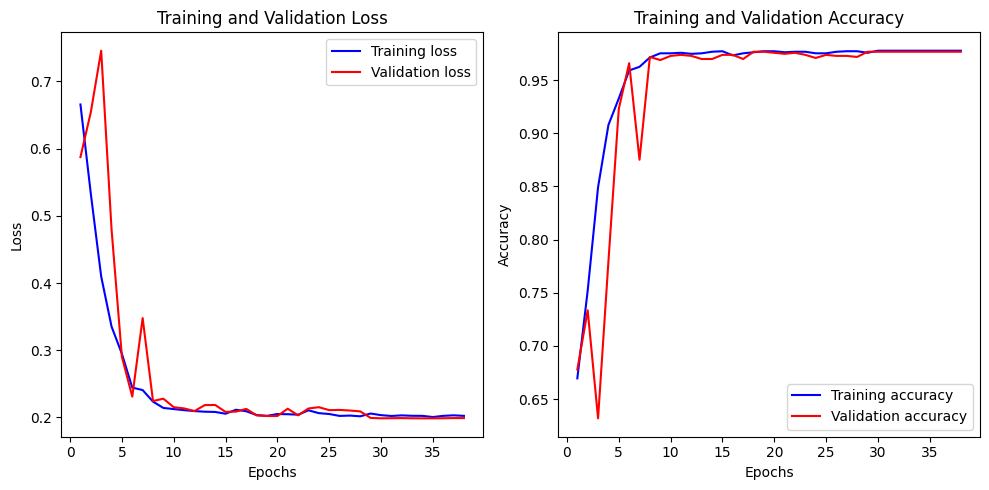

In [21]:
def plot_loss_and_accuracy(history):
    train_loss = [t.detach().cpu().numpy() for t in history['train_loss']]
    val_loss = [t.detach().cpu().numpy() for t in history['val_loss']]
    train_acc = history['train_acc']
    val_acc = history['val_acc']
    
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)


In [22]:
ckpt.update(history)

In [23]:
model.load_state_dict(ckpt['best_model_state_dict'])

<All keys matched successfully>

In [24]:
# # Assuming model and optimizer are already defined
# # Save model parameters
# torch.save(model.state_dict(), 'model.pth')

# # Save optimizer parameters
# torch.save(optimizer.state_dict(), 'optimizer.pth')

In [25]:
def eval_one_step(model, data, optimizer, phase, device):
    batch_loss = batch_corrects = 0
    images = data['image'].to(device)
    targets = data['target'].to(device)
    model.eval()
    with torch.no_grad():
        scores = model(images)
        scores = F.softmax(scores, dim=-1)
        batch_loss = criterion(scores, targets)
    predict_proba, predictions = scores.max(dim=1)
    batch_corrects = (predictions==targets).sum().item()
    return batch_loss, batch_corrects, predict_proba.cpu().numpy(), predictions.cpu().numpy(), targets.cpu().numpy(), scores

In [26]:
phase = 'test'
device = model_args.device
batch_size = model_args.batch_size
epoch_loss = epoch_corrects = epoch_acc = 0
test_label = []
test_pred = []
test_probs = []
test_dataloader = torch.utils.data.DataLoader(datasets['test'], batch_size=model_args.batch_size, shuffle=False)
for batch_index, data in enumerate(test_dataloader):
    batch_loss, batch_corrects, predict_proba, predictions, targets, scores = eval_one_step(model, data, optimizer, phase, device)
    test_probs.append(predict_proba)
    test_pred.append(predictions)
    test_label.append(targets)
    epoch_loss+=batch_loss
    epoch_corrects+=batch_corrects
test_probs = np.concatenate(test_probs)   
test_pred = np.concatenate(test_pred)
test_label = np.concatenate(test_label)

In [27]:
print("Classification Report:\n",classification_report(test_label,test_pred))

print(f"Accuracy score: {accuracy_score(test_label,test_pred):.4f}")
print(f"Precision score: {precision_score(test_label,test_pred):.4f}")
print(f"f1 score: {f1_score(test_label,test_pred):.4f}")
print(f"Recall: {recall_score(test_label,test_pred):.4f}")
print(f"Area Under ROC-Curve: {roc_auc_score(test_label, test_pred):.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       500
           1       0.97      0.99      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

Accuracy score: 0.9840
Precision score: 0.9745
f1 score: 0.9842
Recall: 0.9940
Area Under ROC-Curve: 0.9840


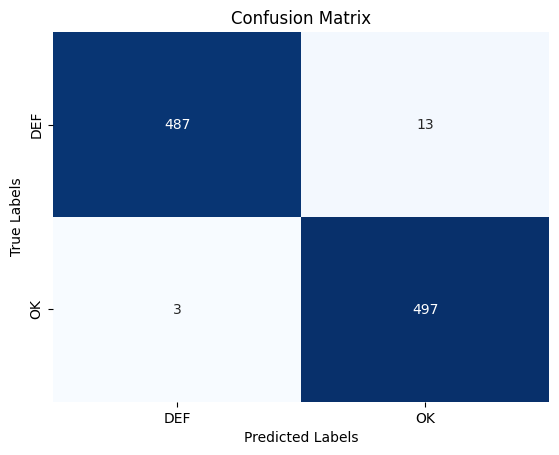

In [28]:
cm = confusion_matrix(test_label,test_pred)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.xticks([0.5, 1.5], ["DEF", "OK"])  # Custom labels for x-axis
plt.yticks([0.5, 1.5], ["DEF", "OK"])  # Custom labels for y-axis
plt.ylabel('True Labels')

plt.show()

In [29]:
print(f"Area Under ROC-Curve: {roc_auc_score(test_label, test_pred):.4f}")

Area Under ROC-Curve: 0.9840


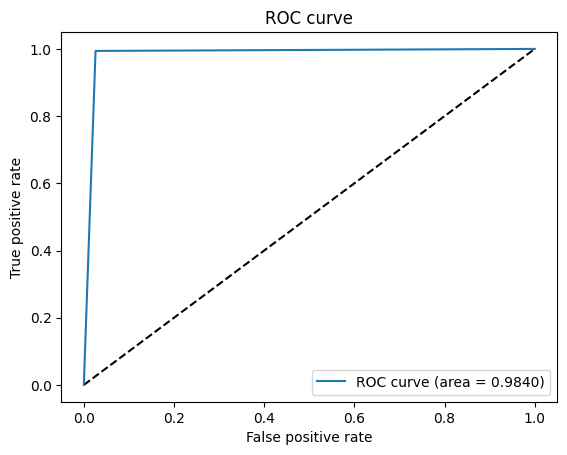

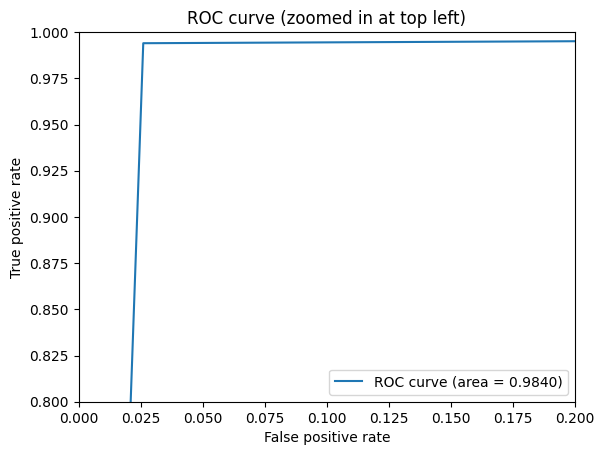

In [30]:
# Not correct, use test_probs instead
fpr, tpr, thresholds = roc_curve(test_label, test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [31]:
1# Define your input data
input_data = torch.randn(1, 3, 180, 180).to(device=model_args.device)  # Example input data of shape (batch_size, channels, height, width)

# Warm-up the model (optional but can help stabilize timing)
for _ in range(10):
    _ = model(input_data)

# Measure the time taken for inference
start_time = time.time()
for _ in range(100):  # Perform inference on 100 batches for better accuracy
    _ = model(input_data)
end_time = time.time()

# Calculate FPS
total_time = end_time - start_time
fps = 100 / total_time  # Number of batches processed per second
print("FPS:", fps)

FPS: 299.1853959032975


In [32]:
from ptflops import get_model_complexity_info
input_size = (3, 180, 180)
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(model, input_size, as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Classifier(
  1.32 M, 99.844% Params, 793.69 MMac, 99.570% MACs, 
  (cnn): VGG_net(
    1.26 M, 94.763% Params, 793.56 MMac, 99.553% MACs, 
    (conv_layers): Sequential(
      1.26 M, 94.763% Params, 793.56 MMac, 99.553% MACs, 
      (0): Conv2d(448, 0.034% Params, 14.52 MMac, 1.821% MACs, 3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, 0.002% Params, 1.04 MMac, 0.130% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(1, 0.000% Params, 518.4 KMac, 0.065% MACs, num_parameters=1)
      (3): Conv2d(2.32 k, 0.175% Params, 75.17 MMac, 9.430% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, 0.002% Params, 1.04 MMac, 0.130% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(1, 0.000% Params, 518.4 KMac, 0.065% MACs, num_parameters=1)
      (6): MaxPool2d(0, 0.000% Params, 518.4 KMac, 0.065% MACs, kernel_size=(2, 2), stride=(2, 2), pa

In [33]:
PATH = '/kaggle/working/ckpt'
torch.save(ckpt,PATH)

In [34]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['best_model_state_dict'])

<All keys matched successfully>